In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pyro
import seaborn as sns

pyro.settings.set(module_local_params=True)

sns.set_style("white")


seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

root = find_repo_root()


smoke_test = "CI" in os.environ
subset_starts = 1  # 420
subset_ends = 30 if smoke_test else 900
desired_frames = 30 if smoke_test else 180
notebook_starts = time.time()

In [2]:
training_data_code = "15EQ20191202"
validation_data_code = "15EQ20191205"
training_data_path = os.path.join(
    root, f"data/foraging/locust/{training_data_code}_tracked.csv"
)
validation_data_path = os.path.join(
    root, f"data/foraging/locust/{validation_data_code}_tracked.csv"
)


tdf = lc.load_and_clean_locust(
    path=training_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)


vdf = lc.load_and_clean_locust(
    path=validation_data_path,
    desired_frames=desired_frames,
    grid_size=100,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=subset_starts,
    subset_ends=subset_ends,
)


training_object = tdf["subset"]
validation_object = vdf["subset"]

training_rewards = (
    training_object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
)

validation_rewards = (
    validation_object.rewardsDF.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True)
)


tdf = training_object.foragersDF
vdf = validation_object.foragersDF

# shared
start, end, N_obs = min(tdf["time"]), max(tdf["time"]), len(tdf["time"].unique())


original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 180
resulting_shape: (2700, 4)
min_time 1
max_time 180
original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 180
resulting_shape: (2700, 4)
min_time 1
max_time 180


In [3]:
ft.animate_foragers(
    training_object,
    plot_rewards=True,
    height=700,
    point_size=10,
)

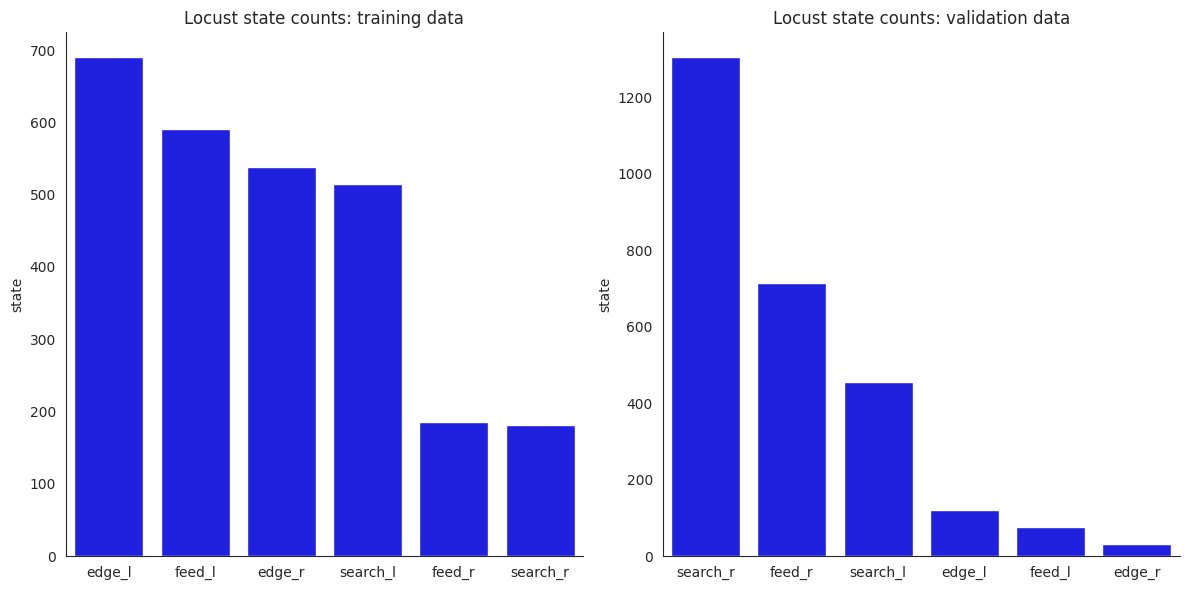

In [6]:
tdf_cat = lc.compartmentalize_locust_data(
    training_rewards, tdf, center=50, feeding_radius=10, edge_ring_width=4
)

vdf_cat = lc.compartmentalize_locust_data(
    validation_rewards, vdf, center=53, feeding_radius=10, edge_ring_width=4
)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(
    x=tdf_cat["state"].value_counts().index,
    y=tdf_cat["state"].value_counts(),
    color="blue",
    ax=axes[0]  
)
axes[0].set_title("Locust state counts: training data")
sns.despine(ax=axes[0])

sns.barplot(
    x=vdf_cat["state"].value_counts().index,
    y=vdf_cat["state"].value_counts(),
    color="blue",
    ax=axes[1]  
)
axes[1].set_title("Locust state counts: validation data")
sns.despine(ax=axes[1])

plt.tight_layout()

#plt.savefig("locust_state_counts.png")
plt.show()

In [7]:
t_unique_states = set(tdf_cat["state"])
v_unique_states = set(vdf_cat["state"])

# these will be added to ensure the animation starts with
# all states represented
# ignore the initial frame in the animation
t_initial_fake_positions = pd.DataFrame(
    {
        "x": np.zeros(len(t_unique_states), dtype=int),
        "y": np.zeros(len(t_unique_states), dtype=int),
        "state": sorted(list(t_unique_states)),
        "time": [(start - 1)] * len(t_unique_states),
        "forager": np.zeros(len(t_unique_states), dtype=int),
    }
)

v_initial_fake_positions = pd.DataFrame(
    {
        "x": np.zeros(len(v_unique_states), dtype=int),
        "y": np.zeros(len(v_unique_states), dtype=int),
        "state": sorted(list(v_unique_states)),
        "time": [(start - 1)] * len(v_unique_states),
        "forager": np.zeros(len(v_unique_states), dtype=int),
    }
)


t_df_cat_vis = pd.concat([t_initial_fake_positions, tdf_cat])
training_object.foragersDF = t_df_cat_vis

v_df_cat_vis = pd.concat([v_initial_fake_positions, vdf_cat])
validation_object.foragersDF = v_df_cat_vis

ft.animate_foragers(
    training_object,
    plot_rewards=True,
    height=600,
    point_size=10,
    color_by_state=True,
)

# note they tend to be on the right side
# unlike in the training data
# this is a good thing
ft.animate_foragers(
    validation_object,
    plot_rewards=True,
    height=600,
    point_size=10,
    color_by_state=True,
)